In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


In [3]:
xr.open_dataset('/homedata/nmpnguyen/ORACLES-ER2/HSRL2_ER2_20160819_R8.h5', group= 'DataProducts')


<xarray.Dataset>
Dimensions:                  (phony_dim_0: 1404, phony_dim_1: 1389, phony_dim_2: 1, phony_dim_3: 701)
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2, phony_dim_3
Data variables: (12/45)
    1064_aer_dep             (phony_dim_0, phony_dim_1) float64 ...
    1064_bsc                 (phony_dim_0, phony_dim_1) float64 ...
    1064_bsc_Sa              (phony_dim_0, phony_dim_1) float64 ...
    1064_bsc_cloud_screened  (phony_dim_0, phony_dim_1) float64 ...
    1064_bsr                 (phony_dim_0, phony_dim_1) float64 ...
    1064_bsr_cloud_screened  (phony_dim_0, phony_dim_1) float64 ...
    ...                       ...
    Dust_Mixing_Ratio        (phony_dim_0, phony_dim_1) float64 ...
    Mask_cirrus              (phony_dim_0, phony_dim_3) float64 ...
    WVD_1064_532             (phony_dim_0, phony_dim_1) float64 ...
    WVD_532_355              (phony_dim_0, phony_dim_1) float64 ...
    cloud_top_height         (phony_dim_0, phony_dim_2) float64 ...
    mask_low                 (phony_dim_0, phony_dim_1) float64 ...

In [13]:
a = np.arange(2006,2036)
b = [0]*len(a)
print(a, b)

[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033
 2034 2035] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


(-1.0, 1.0)

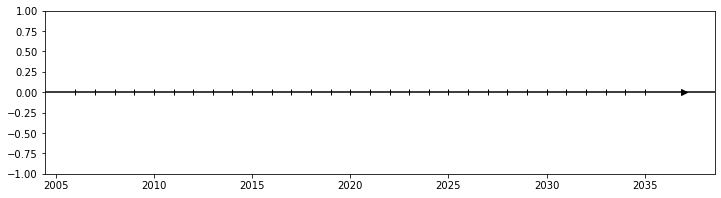

In [17]:
f, ax=plt.subplots(figsize=(12,3))
ax.plot(a, [0]*len(a), '|', color='k')
ax.axhline(0, color='k')
ax.plot(2037, 0, '>', color='k')
ax.set_ylim(-1,1)

In [6]:
df = pd.read_pickle('/homedata/nmpnguyen/OPAR/Processed/LI1200/2018-06-19_simul.pkl')

In [8]:
dt_to_xrDataset = xr.Dataset.from_dataframe(df)
print(dt_to_xrDataset)

<xarray.Dataset>
Dimensions:   (range: 16380, time: 178)
Coordinates:
  * time      (time) datetime64[ns] 2018-06-19T17:54:06 ... 2018-06-19T20:52:55
  * range     (range) float64 2.16e+03 2.175e+03 ... 2.478e+05 2.478e+05
Data variables:
    pression  (time, range) float64 7.844e+04 7.83e+04 ... -1.057e+04 -1.057e+04
    ta        (time, range) float64 285.6 285.7 285.8 ... 305.9 305.9 305.9


In [95]:
xr.open_dataset('./OPAR/LI1200.daily/2020-08-18.nc4').to_dict(data=False)['data_vars']['signal']['attrs']


{'alt_station(km)': 2.158,
 'start_time': '2020-08-18 14:54:38',
 'end_time': '2020-08-18 14:55:38',
 'long_name': 'signal',
 'location': 'MAIDO',
 'longitude': '0055.3',
 'latitude': '-021.1',
 'angle_zenith': '00'}

In [171]:
def option_database(type_database, filepath):
    if type_database == 'opar':
        output_dataset_dict = transfert_opar_database(filepath)
#     elif type_database == 'ipral':
#     elif type_database == 'er2_hsrl2':
#     elif type_database == 'lng_hsrl':
    else:
        print('Please entry type_database')

def transfert_opar_database(filepath):
    data = xr.open_dataset(filepath)
    time_arr = data['time'].values
    range_arr = data['range'].values
    latitude_sol = data['signal'].attrs['latitude']
    longitude_sol = data['signal'].attrs['longitude']
    alt_station = data['signal'].attrs['alt_station(km)']
    start_time = data['signal'].attrs['start_time']
    end_time = data['signal'].attrs['end_time']
#     attrs_dict = data.to_dict(data=False)['data_vars']['signal']['attrs']    
    data_dict = {
        "coords": {
            "time": {"dims": "time", "data": time_arr},
            "range": {"dims": "range", "data": range_arr*1e3, "attrs": {"units": "m"}},
            },
        "attrs": {
            "lat": float(latitude_sol),
            "lon": float(longitude_sol),
            "start_time": pd.to_datetime(start_time),
            "end_time": pd.to_datetime(end_time),
             },
        "dims": {"time": len(time_arr), "range": len(range_arr)},
        "data_vars": {
            "altitude": {"dims": "range", "data": (range_arr+alt_station)*1e3, "attrs": {"units": "m"}},
            },
    }
    return data_dict 

def transfert_ipral_database(filepath):
    data = xr.open_dataset(filepath)
    if (pd.to_datetime(data['time'].values[0]).day == pd.to_datetime(Path(filepath).stem.split('_')[4]).day):
        start_time = data['time'].values[0].astype('str')
    else:
        start_time = pd.to_datetime(Path(filepath).stem.split('_')[4])
    end_time = data['time'].values[-1].astype('str')
    print(type(end_time))
    time_arr = data['time'].values
    range_arr = data['range'].values  
    altitude = data['altitude'].values 
    latitude_sol = data.attrs['geospatial_lat_min']
    longitude_sol = data.attrs['geospatial_lon_min']
    data_dict = {
        "coords": {
            "time": {"dims": "time", "data": time_arr},
            "range": {"dims": "range", "data": range_arr},
            },
        "attrs": {
            "lat": float(latitude_sol),
            "lon": float(longitude_sol),
            "start_time": start_time,
            "end_time": end_time,
             },
        "dims": {"time": len(time_arr), "range": len(range_arr)},
        "data_vars": {
            "altitude": {"dims": "range", "data": altitude+range_arr},
            },
    }
    return data_dict

In [151]:
# transfert_opar_database('./OPAR/LI1200.daily/2020-08-18.nc4')
tmp_file = xr.Dataset.from_dict(transfert_opar_database('./OPAR/LI1200.daily/2020-08-18.nc4'))

In [172]:
tmp_file = xr.Dataset.from_dict(transfert_ipral_database('/bdd/SIRTA/pub/basesirta/1a/ipral/2020/01/06/ipral_1a_Lz1R15mF30sPbck_v01_20200106_000000_1440.nc'))
tmp_file.to_netcdf('tmp.nc', 'w')
# xr.open_dataset('/bdd/SIRTA/pub/basesirta/1a/ipral/2020/01/06/ipral_1a_Lz1R15mF30sPbck_v01_20200106_000000_1440.nc').attrs['geospatial_lat_min']

<class 'numpy.str_'>


In [177]:
str(pd.to_datetime(tmp_file.attrs['start_time']).year)

'2020'

In [160]:
np.unique(pd.to_datetime(tmp_file.time).strftime('%Y-%m-%dT%H:00:00.000000').astype('datetime64[ns]'))

DatetimeIndex(['2020-01-06 11:00:00', '2020-01-06 11:00:00',
               '2020-01-06 11:00:00', '2020-01-06 11:00:00',
               '2020-01-06 11:00:00', '2020-01-06 11:00:00',
               '2020-01-06 11:00:00', '2020-01-06 11:00:00',
               '2020-01-06 12:00:00', '2020-01-06 12:00:00',
               ...
               '2020-01-06 17:00:00', '2020-01-06 17:00:00',
               '2020-01-06 17:00:00', '2020-01-06 17:00:00',
               '2020-01-06 17:00:00', '2020-01-06 17:00:00',
               '2020-01-06 17:00:00', '2020-01-06 17:00:00',
               '2020-01-06 17:00:00', '2020-01-06 17:00:00'],
              dtype='datetime64[ns]', length=370, freq=None)